In [1]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import pickle
from timeit import timeit
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import logging
from config import arch_config
import matplotlib.ticker as mtick

logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [2]:
se.set_style("darkgrid")

5.826123667891853

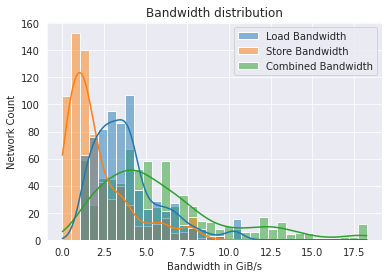

In [3]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

bw_df = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['load_bw', 'store_bw'])].div(2**30)
bw_df["combined"] = bw_df["load_bw"] + bw_df["store_bw"]
bw_df = bw_df.rename(columns={'load_bw': "Load Bandwidth", "store_bw": "Store Bandwidth", "combined":"Combined Bandwidth"})
plt = se.histplot(data = bw_df, kde=True)
plt.set_xlabel('Bandwidth in GiB/s')
plt.set_ylabel('Network Count')
plt.set_title('Bandwidth distribution')
bw_df["Combined Bandwidth"].mean()

Load Bandwidth        31.653994
Store Bandwidth       29.746200
Combined Bandwidth    50.809996
dtype: float64

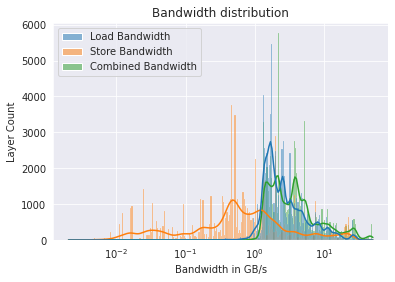

In [4]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
arch_metrics = arch_metrics[['load_bw', 'store_bw']].div(2**30)
arch_metrics['combined'] = arch_metrics['load_bw'] + arch_metrics['store_bw']
bw_df = arch_metrics
bw_df = bw_df.rename(columns={'load_bw': "Load Bandwidth", "store_bw": "Store Bandwidth", "combined":"Combined Bandwidth"})
plt = se.histplot(data = bw_df, kde=True, log_scale=True)
plt.set_xlabel('Bandwidth in GB/s')
plt.set_ylabel('Layer Count')
plt.set_title('Bandwidth distribution')
bw_df.max()

Text(0.5, 0, 'Total chip area: 0.34$mm^2$')

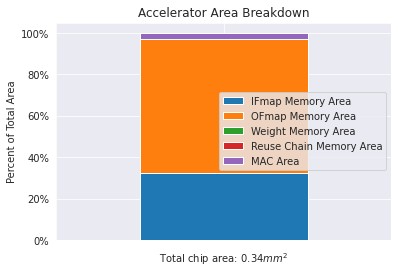

In [5]:
from config import arch_config, area_model

filter_count = arch_config['filter_count']
channel_count = arch_config['channel_count']
pe_count = filter_count*channel_count
ifmap_bank_size = arch_config['ifmap_mem_ub'] / channel_count
ifmap_bank_count = channel_count
ifmap_bank_precision = 8
ofmap_bank_size = arch_config['ifmap_mem_ub'] / filter_count
ofmap_bank_precision = 16
ofmap_bank_count = filter_count
weight_bank_size = arch_config['weight_bank_size']
weight_bank_precision = 8
weight_bank_count = pe_count
reuse_chain_bank_size = arch_config['reuse_chain_bank_size']
reuse_chain_bank_precision = 8
reuse_chain_bank_count = channel_count/9 * 2


area_breakdown = {
    'IFmap Memory Area': area_model['sram'](ifmap_bank_size, ifmap_bank_precision, ifmap_bank_count),
    'OFmap Memory Area': area_model['sram'](ofmap_bank_size, ofmap_bank_precision, ofmap_bank_count),
    "Weight Memory Area": area_model['sram'](weight_bank_size, weight_bank_precision, weight_bank_count),
    "Reuse Chain Memory Area": area_model['sram'](reuse_chain_bank_size, reuse_chain_bank_precision, reuse_chain_bank_count),
    'MAC Area': area_model['mac'](pe_count)
}

total = sum(area_breakdown.values())
area_breakdown = {k:v/total*100 for k, v in area_breakdown.items()}
area_breakdown[""] = ""
area_breakdown = pd.DataFrame.from_records([area_breakdown], index="")
plt = area_breakdown.plot(kind='bar', stacked=True)
plt.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.set_title("Accelerator Area Breakdown")
plt.set_ylabel("Percent of Total Area")
plt.set_xlabel(f'Total chip area: {total*10**-6:.2f}'+ r'$mm^2$')